In this project we are going to train a vq-vae model to generate images of the anime faces dataset. 

In [2]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
anime_path = "../data/anime_face"

In [5]:
dataset = datasets.ImageFolder(
    root=anime_path,
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
)

train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

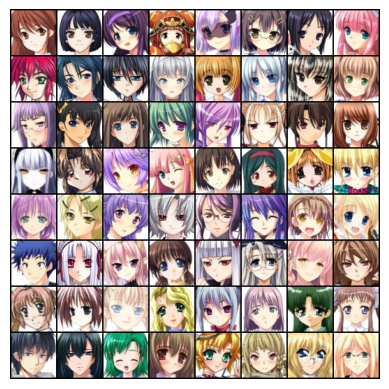

In [7]:
def show_images(images):
    images = make_grid(images, nrow=8)
    plt.imshow(images.permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    
images, _ = next(iter(train_loader))
show_images(images)